## <center> Time Series Models with Multiple Linear Regression Activity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV
import time

In [2]:
df = pd.read_csv('stock_data.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [3]:
df.index = pd.DatetimeIndex(df.Date)

In [5]:
## create list of dataframes and stock names
stock_dfs = []
stock_names = []
for stock in df.Name.unique():
    stock_dfs.append(pd.DataFrame(df[df['Name']==stock][['Close']].copy()))
    stock_names.append(stock)

In [6]:
stock_names

['MMM', 'GS', 'UNH']

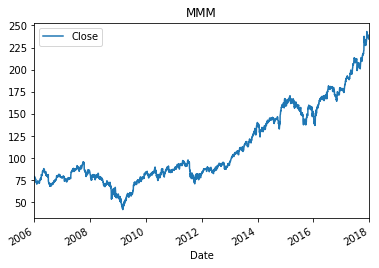

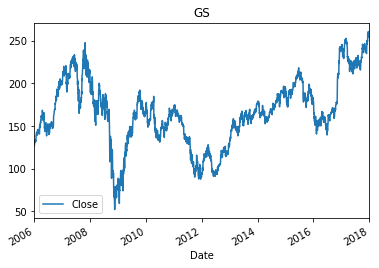

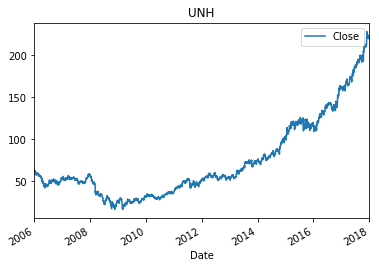

In [7]:
## plot each stock
for df_,name in zip(stock_dfs,stock_names):
    df_.plot()
    plt.title(name)
    plt.show()

In [8]:
## Generate features and fit model, storing new dataframes and models in lists
test_period = 14
stock_dfs_ = []
models = []
for df_ in stock_dfs:
    ## month and day features
    df_['Month'] = df_.index.month
    df_['Day'] = df_.index.dayofyear
    df_['Year'] = df_.index.year - np.min(df_.index.year)
    date_features = ['Month', 'Day', 'Year']
    ## month and day polynomials
    polynomial_terms = [2,3]
    for feature in date_features:
        for i in polynomial_terms:
            df_[feature+'**'+str(i)] = df_[feature]**i
    ## previous values and polynomials
    previous_values_range = 100
    for i in range(1,previous_values_range):
        df_['Previous'+str(i)] = df_['Close'].shift(i).bfill()
        for j in polynomial_terms:
            df_['Previous'+str(i)+'**'+str(j)] = (df_['Close'].shift(i).bfill())**j
    ## fit model
    reg = LassoLarsCV(cv=5).fit(df_.drop(['Close'],axis=1)[:-test_period], df_['Close'][:-test_period])
    stock_dfs_.append(df_)
    models.append(reg)

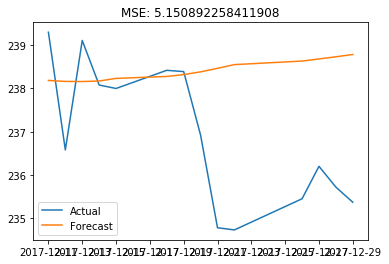

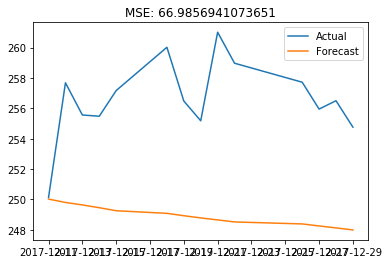

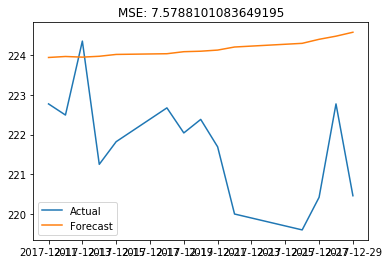

Time: 4.630622625350952 seconds.


In [21]:
## generate forecasts on test period, store forecast dataframes, output MSE and plots
forecast_dfs = []
start = time.time()
for model, df_ in zip(models, stock_dfs_):
    actual = df_[-test_period:]['Close']
    forecast = []
    ## create and populate forecast dataframe
    forecast_df = df_.copy()
    for datetime, date in zip(df_.index[-test_period:], range(len(df_)-test_period, len(df_))):
        values = []
        ## add datetime components
        values.append(datetime.month)
        values.append(datetime.dayofyear)
        values.append(datetime.year - np.min(df_.index.year))
        ## add polynomial terms of datetime components
        for feature in date_features:
            for i in polynomial_terms:
                values.append((forecast_df[feature][date])**i)
        ## add previous values and polynomial terms of previous values
        for i in range(1,previous_values_range):
            values.append(forecast_df['Close'][date-i])
            for j in polynomial_terms:
                values.append((forecast_df['Close'][date-i])**j)
        ## make prediction on current datetime
        forecast_ = model.predict(np.array(values).reshape(1,-1))[0]
        forecast.append(forecast_)
        ## append prediction to start of values array
        values.insert(0, forecast_)
        ## set forecast row in dataframe
        forecast_df.loc[datetime] = values
    plt.plot(df_[-test_period:].index, actual)
    plt.plot(df_[-test_period:].index, forecast)
    plt.legend(['Actual', 'Forecast'])
    plt.title('MSE: '  + str(mean_squared_error(actual, forecast)))
    plt.show()
    forecast_dfs.append(forecast_df)
print('Time:', time.time()-start, 'seconds.')

In [22]:
## view features selected
for i,stock in zip(models,stock_names): 
    selected_features = pd.DataFrame()
    selected_features['Feature'] = stock_dfs_[0].drop('Close',axis=1).columns[i.coef_>0]
    selected_features['Coefficient'] = i.coef_[i.coef_>0]
    selected_features.sort_values('Coefficient')
    print(stock)
    print(selected_features)
    print('--------------------------------')

MMM
         Feature   Coefficient
0        Year**2  4.687804e-03
1      Previous1  9.519057e-01
2      Previous2  3.382004e-02
3      Previous6  6.629082e-03
4  Previous68**3  7.833437e-08
5     Previous73  1.431327e-04
--------------------------------
GS
     Feature   Coefficient
0     Day**3  1.327814e-09
1    Year**3  1.528818e-04
2  Previous1  9.445388e-01
3  Previous2  3.175631e-02
4  Previous7  1.327806e-02
5  Previous9  5.667575e-03
--------------------------------
UNH
          Feature   Coefficient
0         Year**2  1.404607e-03
1         Year**3  3.265039e-04
2       Previous1  9.649976e-01
3       Previous5  9.035632e-04
4       Previous7  1.091961e-02
5      Previous11  4.494027e-03
6      Previous17  2.193273e-03
7      Previous22  1.080589e-02
8      Previous56  1.049214e-04
9   Previous81**3  1.800750e-08
10  Previous92**3  6.812186e-08
--------------------------------


In [23]:
## predicting tomorrow's prices, fitting model to entire dataset
start = time.time()
todays = []
tomorrows = []
datetime = pd.to_datetime('2017-12-30')
tomorrow_date = len(stock_dfs[0])
today_date = len(stock_dfs[0])-1
for df_ in stock_dfs_:
    ## fit final model to entire dataset
    model = LassoLarsCV(cv=5).fit(df_.drop(['Close'],axis=1), df_['Close'])
    values = []
    ## add datetime components
    values.append(datetime.month)
    values.append(datetime.dayofyear)
    values.append(datetime.year - np.min(df_.index.year))
    ## add polynomial terms of datetime components
    values.append((datetime.month)**2)
    values.append((datetime.month)**3)
    values.append((datetime.dayofyear)**2)
    values.append((datetime.dayofyear)**3)
    values.append((datetime.year - np.min(df_.index.year))**2)
    values.append((datetime.year - np.min(df_.index.year))**3)
    ## add previous values and polynomial terms of previous values
    for i in range(1,previous_values_range):
        values.append(df_['Close'][tomorrow_date-i])
        for j in polynomial_terms:
            values.append((df_['Close'][tomorrow_date-i])**j)
    ## make prediction on current datetime
    forecast = model.predict(np.array(values).reshape(1,-1))[0]
    todays.append(df_['Close'][-1])
    tomorrows.append(forecast)

In [24]:
## view predictions for next day
predictions = pd.DataFrame()
predictions['Stock'] = stock_names
predictions['Today'] = todays
predictions['Tomorrow'] = tomorrows
predictions['Change'] = predictions['Today'] - predictions['Tomorrow']
predictions

,Stock,Today,Tomorrow,Change
0,MMM,235.37,235.436454,-0.066454
1,GS,254.76,254.693880,0.066120
2,UNH,220.46,220.590634,-0.130634


### From these predictions, we should invest in stock GS.